# Iteration 6: Regression

## Load data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
#df = pd.read_csv('./data/housing_iteration_3_classification.csv')
df = pd.read_csv('./data/housing_iteration_6_regression.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
for col in df.select_dtypes(exclude="number").columns:
    #print(df[col].value_counts())
    pass

## Create intuitive dummy model

As baseline, we can assume that LotArea is a good predictor for price. By eyeballing, we estimate a linear function that fits the data well. This is our intuitive baseline model.

In [5]:
def dummy_model(area):
    return 50 * area - 200000

dummy_model(5000)

50000

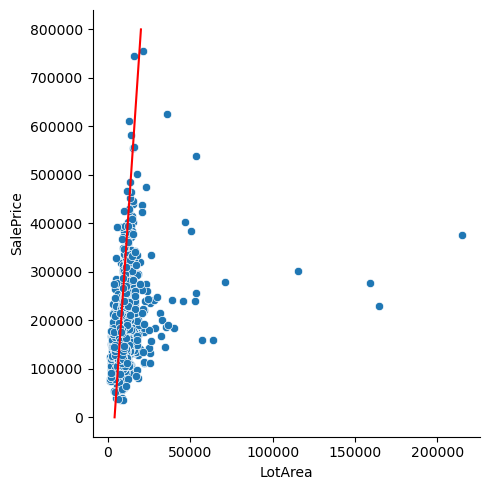

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df, x='LotArea', y='SalePrice')

x1, x2 = 4000, 20000
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

## Train-test split

In [7]:
# define X and y
id = df.pop('Id')
y = df.pop('SalePrice')
X = df.copy()
#X = X.drop(['Alley', 'PoolQC', 'MiscFeature'], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                   random_state=42)

In [9]:
#X_train.info()

In [10]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['LotArea'])
dummy_y_test_pred

892     220700
1105    412800
413     248000
522      50000
1036    444900
         ...  
479      96250
1361    607900
802     209950
651     254200
722     206000
Name: LotArea, Length: 292, dtype: int64

## Assessing regression error

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

def calc_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true = y_true,
                              y_pred = y_pred)
    
    rmse = mean_squared_error(y_true = y_true,
                              y_pred = y_pred,
                              squared=False)

    mape = mean_absolute_percentage_error(y_true = y_true,
                                          y_pred = y_pred)
    
    r2 = r2_score(y_true = y_true, y_pred = y_pred)

    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
    
    print('MAE', mae)
    print('RMSE', rmse)
    print('MAPE', mape)
    print('R2', r2)
    
    return metrics

calc_metrics(y_test, dummy_y_test_pred)

MAE 167837.20890410958
RMSE 301210.36553406954
MAPE 1.111223328965433
R2 -10.828399712668753


{'MAE': 167837.20890410958,
 'RMSE': 301210.36553406954,
 'MAPE': 1.111223328965433,
 'R2': -10.828399712668753}

## Build Pipeline

### Define preprocessing steps

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").columns
X_num_columns = X.select_dtypes(include="number").columns

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median')), 
           #('num_scaler', MinMaxScaler())
          ])

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[('cat_imputer', SimpleImputer(strategy='constant', 
                                         fill_value='na')), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'#,infrequent_if_exist', 
                                         #min_frequency=0.03
                                        ))
           #('cat_encoder', OrdinalEncoder())
          ])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ])

In [15]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', '...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

### Define regressors to test

In [16]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

In [17]:
regressors = [
    ('DecisionTree', DecisionTreeRegressor()),
    #('SGD', SGDRegressor()),
    #('LinReg', LinearRegression())
]

### Create a pipeline for each classifier

In [18]:
pipelines = {}
for name, reg in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('scaler', StandardScaler()), 
                           ('regressor', reg)]).set_output(transform='pandas')
    pipelines[name] = pipe


In [19]:
pipelines['DecisionTree']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea'...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('regressor', DecisionTreeRegressor())])

## Inspect models

In [20]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    
    resid = pd.DataFrame()
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # calc residuals
    resid['predicted'] = y_pred.copy()
    resid['observed'] = y_test.copy()
    resid['residual'] = resid['predicted'] - resid['observed']

    # save
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = resid

DecisionTree
MAE 27817.80821917808
RMSE 42873.80705101829
MAPE 0.1643081633671314
R2 0.7603539560904751


/home/philip/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
compare_models = pd.DataFrame(metrics)
compare_models

,DecisionTree
MAE,27817.808219
MAPE,0.164308
R2,0.760354
RMSE,42873.807051


DecisionTree


/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


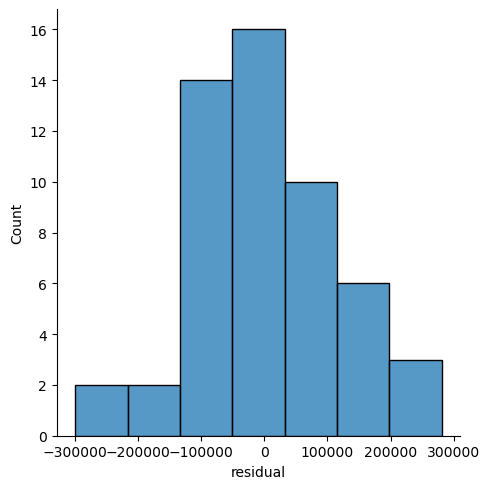

In [22]:
for name in residuals:
    print(name)
    r = residuals[name]
    sns.displot(r['residual'])

DecisionTree (292, 3)


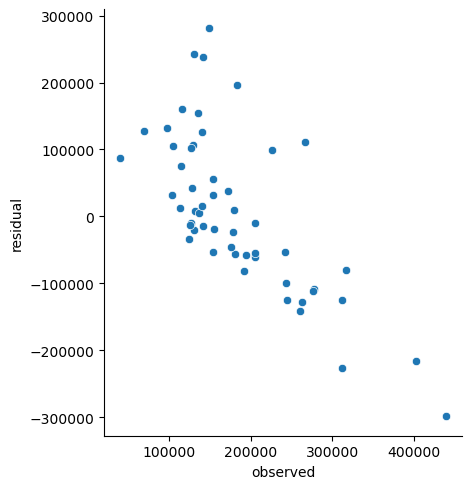

In [23]:
for name in residuals:
    r = residuals[name]
    print(name, r.shape)
    sns.relplot(data=r, x='observed', y='residual')

## Exploratory hyperparameter search

### Define exploratory hyperparameters

In [26]:
param_grids_explore = {
    'DecisionTree': {
        'regressor__max_depth': [3, 5, 7, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': [None, 'sqrt', 'log2']
    }
}


### Fit and evaluate models

In [33]:
#TODO: still problems in the input data, gridsearch does not converge... solve issue!

In [29]:
from sklearn.model_selection import GridSearchCV

#import warnings
#warnings.filterwarnings('ignore')

In [30]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=5, scoring='accuracy',
                              verbose=2)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_explore[name] = grid_search.best_score_
        params_explore[name] = grid_search.best_params_


Training and evaluating DecisionTree...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.1s
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.1s
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.1s
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.1s
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.1s
[CV] END regressor__max_depth=3, regressor__max_features=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.1s
[CV] END regressor__max_de

In [31]:
scores_explore

{'DecisionTree': nan}

In [32]:
params_explore

{'DecisionTree': {'regressor__max_depth': 3,
  'regressor__max_features': None,
  'regressor__min_samples_leaf': 1,
  'regressor__min_samples_split': 2}}